In [91]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import time

import torch
from torch import nn
import torch.optim as optim

In [92]:
import nodepy

In [93]:
sys.path.append("/Users/yogeshkawadkar/Desktop/data_augmentation_for_multivariate_time_series/sysid-neural-continuous/torchid")


In [94]:
from ssmodels_ct import NeuralStateSpaceModel, DeepNeuralStateSpaceModel
from ss_simulator_ct import ForwardEulerSimulator, ExplicitRKSimulator

In [95]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f'Using device {device}')

Using device cpu


In [96]:
path_dataset = "/Users/yogeshkawadkar/Desktop/data_augmentation_for_multivariate_time_series/datasets/Audi a2d2/camera_lidar/20180810_150607/bus/20180810150607_bus_signals.json"
# path_dataset = '/home/benny/Datasets/camera_lidar/20190401_121727_Munich/bus/20190401121727_bus_signals.json'
# path_dataset = '/home/benny/Datasets/camera_lidar/20190401_145936_Ingolstadt/bus/20190401145936_bus_signals.json'
#location = path_dataset.split('/')[8].split('_')[2]
#save_plots_dir = f"/results/{location}"

In [97]:
with open(path_dataset, "rb") as infile:
    dict_data = json.load(infile)

In [98]:
for i, k in enumerate(dict_data.keys()):
    unit_k = dict_data[k]['unit']
    print(f' {i:3} | {k:35} | {unit_k}')

   0 | acceleration_x                      | Unit_MeterPerSeconSquar
   1 | acceleration_y                      | Unit_MeterPerSeconSquar
   2 | acceleration_z                      | Unit_MeterPerSeconSquar
   3 | accelerator_pedal                   | Unit_PerCent
   4 | accelerator_pedal_gradient_sign     | None
   5 | angular_velocity_omega_x            | Unit_DegreOfArcPerSecon
   6 | angular_velocity_omega_y            | Unit_DegreOfArcPerSecon
   7 | angular_velocity_omega_z            | Unit_DegreOfArcPerSecon
   8 | brake_pressure                      | Unit_Bar
   9 | distance_pulse_front_left           | None
  10 | distance_pulse_front_right          | None
  11 | distance_pulse_rear_left            | None
  12 | distance_pulse_rear_right           | None
  13 | latitude_degree                     | Unit_DegreOfArc
  14 | latitude_direction                  | None
  15 | longitude_degree                    | Unit_DegreOfArc
  16 | longitude_direction                 | None
  

In [99]:
input_signals = [
    'accelerator_pedal',
    'brake_pressure',
    'steering_angle_calculated',
    'steering_angle_calculated_sign',
    # 'pitch_angle',
    # 'roll_angle'
]

output_signals = [
    'acceleration_x',
    'acceleration_y',
    'acceleration_z',
    'angular_velocity_omega_x',
    'angular_velocity_omega_y',
    'angular_velocity_omega_z',
    'vehicle_speed',
    # 'latitude_degree',
    # 'longitude_degree',
]

variant_str = 'angle_as_inputs'

dict_signals = {}
dict_time = {}
for signame in input_signals + output_signals:
    t_i, sig_i = zip(*dict_data[signame]['values'])
    t_i, sig_i = np.array(t_i), np.array(sig_i)
    # if signame in ['latitude_degree', 'longitude_degree']:
        # sig_i = sig_i - sig_i[0]
    dict_signals[signame] = sig_i
    dict_time[signame] = t_i

In [73]:
# plot temporal signal information
for k in dict_time.keys():
    time_k = dict_time[k]
    print(f'{k:30} | {int(np.min(time_k)//1e6):11d} | {int(np.max(time_k)//1e6):11d} | {time_k.shape[0]:7d} | {(np.max(time_k) - np.min(time_k)) / time_k.shape[0] * 1e-6:.3e}')

accelerator_pedal              |  1533906414 |  1533906940 |   52576 | 1.000e-02
brake_pressure                 |  1533906414 |  1533906940 |   52576 | 1.000e-02
steering_angle_calculated      |  1533906414 |  1533906940 |   52577 | 1.000e-02
steering_angle_calculated_sign |  1533906414 |  1533906940 |   52577 | 1.000e-02
acceleration_x                 |  1533906414 |  1533906940 |  105153 | 5.000e-03
acceleration_y                 |  1533906414 |  1533906940 |  105153 | 5.000e-03
acceleration_z                 |  1533906414 |  1533906940 |  105153 | 5.000e-03
angular_velocity_omega_x       |  1533906414 |  1533906940 |  105153 | 5.000e-03
angular_velocity_omega_y       |  1533906414 |  1533906940 |  105153 | 5.000e-03
angular_velocity_omega_z       |  1533906414 |  1533906940 |  105153 | 5.000e-03
vehicle_speed                  |  1533906414 |  1533906940 |   26288 | 2.000e-02


In [74]:
# sampling_time_in_seconds = 0.05
sampling_time_in_seconds = 0.5 #0.5

t_min_in_s = np.min(dict_time['acceleration_x']) / 1e6
t_max_in_s = np.max(dict_time['acceleration_x']) / 1e6
t_interp = np.arange(0, t_max_in_s-t_min_in_s, step=sampling_time_in_seconds)


In [75]:
# interpolate all signals to common sampling grid

list_input_signals = []
for signame in input_signals:
    t_sig_norm = (dict_time[signame] - np.min(dict_time[signame])) / 1e6
    sig_i = np.interp(t_interp, t_sig_norm, dict_signals[signame])
    list_input_signals.append(sig_i)
    
list_output_signals = []
for signame in output_signals:
    t_sig_norm = (dict_time[signame] - np.min(dict_time[signame])) / 1e6
    sig_i = np.interp(t_interp, t_sig_norm, dict_signals[signame])
    list_output_signals.append(sig_i)
    
U = np.stack(list_input_signals, axis=-1).astype('float32')
X = np.stack(list_output_signals, axis=-1).astype('float32')

In [76]:
def compute_mean_and_stddev(x):
    return np.mean(x, axis=0), np.std(x, axis=0)

def normalize(x, mean, std):
    return (x - mean) / std


# mean_U_train, std_U_train = compute_mean_and_stddev(U_train)
# mean_X_train, std_X_train = compute_mean_and_stddev(X_train)

# U_train = normalize(U_train, mean_U_train, std_U_train)
# U_val   = normalize(U_val, mean_U_train, std_U_train)
# X_train = normalize(X_train, mean_X_train, std_X_train)
# X_val   = normalize(X_val, mean_X_train, std_X_train)

mean_U, std_U = compute_mean_and_stddev(U)
mean_X, std_X = compute_mean_and_stddev(X)

U = normalize(U, mean_U, std_U)
X = normalize(X, mean_X, std_X)

In [77]:
p_train = 0.5
T_train = int(p_train * X.shape[0])
idxs_train = np.arange(X.shape[0]) < T_train
t_interp_train, t_interp_val = t_interp[idxs_train], t_interp[~idxs_train]
U_train, U_val = U[idxs_train], U[~idxs_train]
X_train, X_val = X[idxs_train], X[~idxs_train]

Inputs


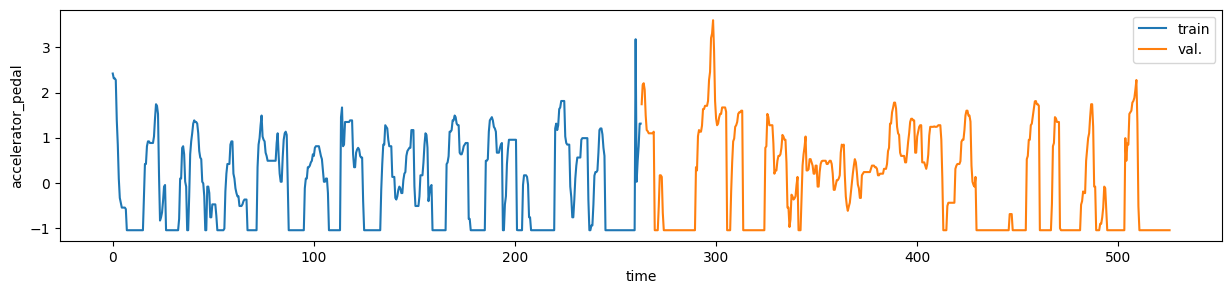

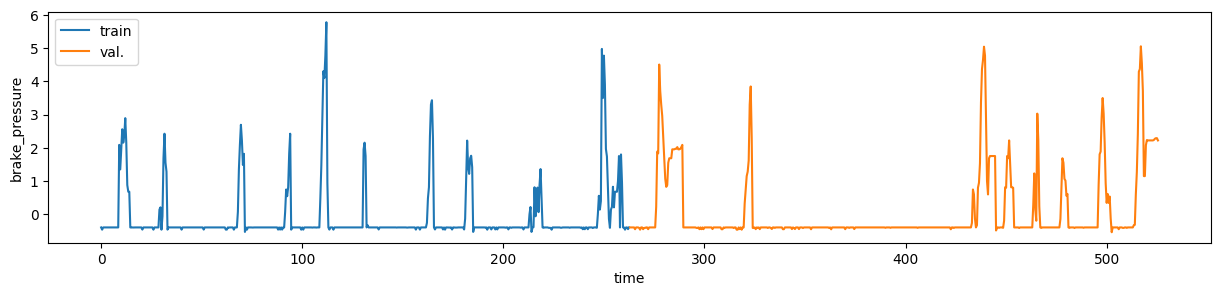

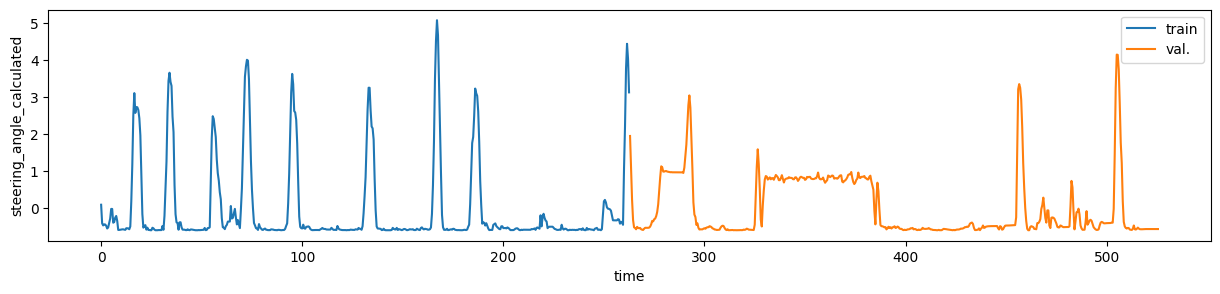

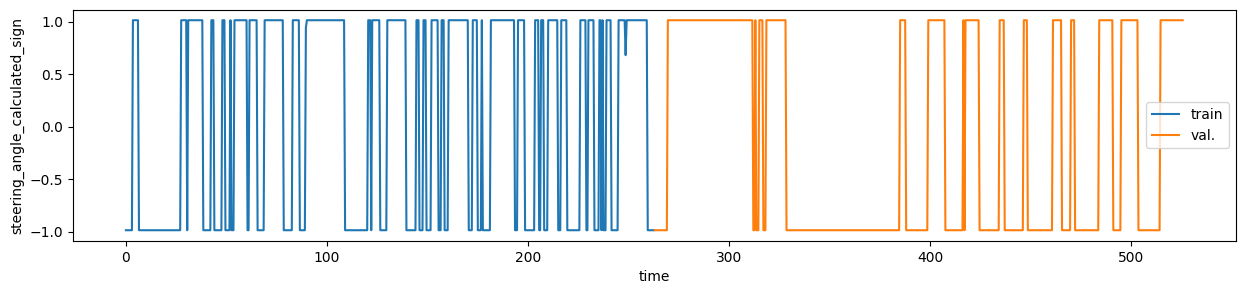

Outputs


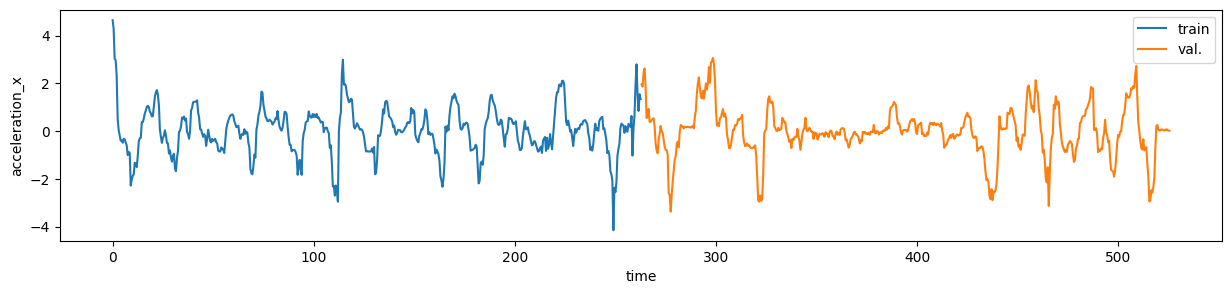

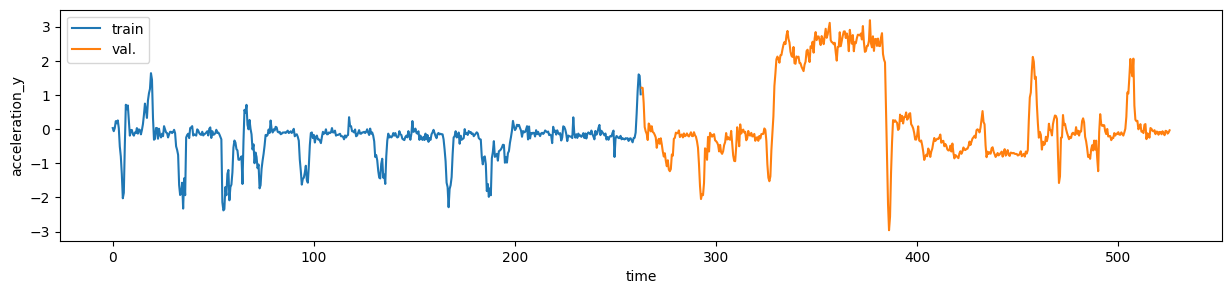

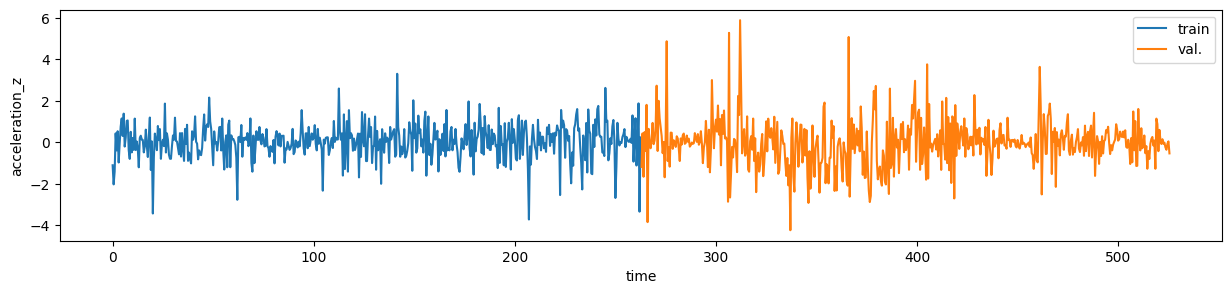

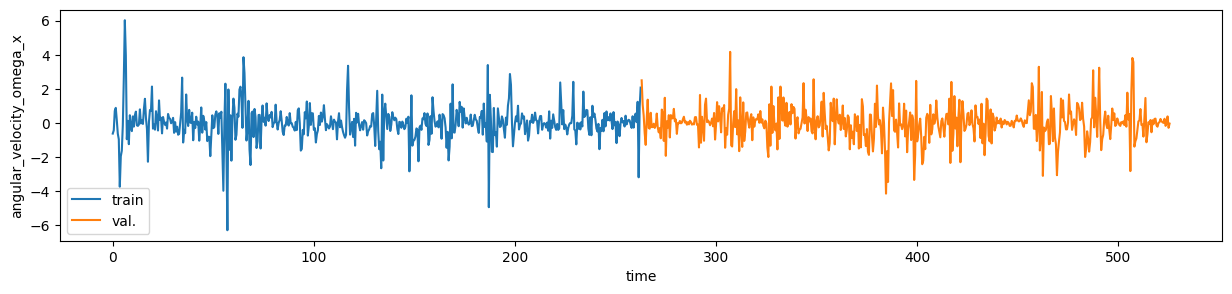

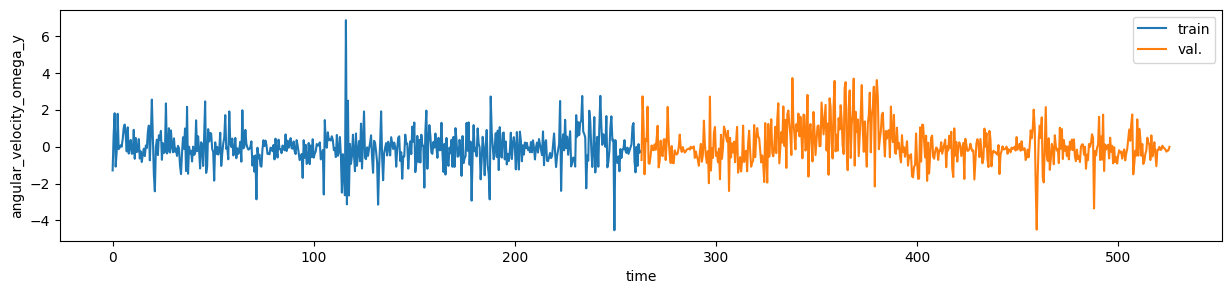

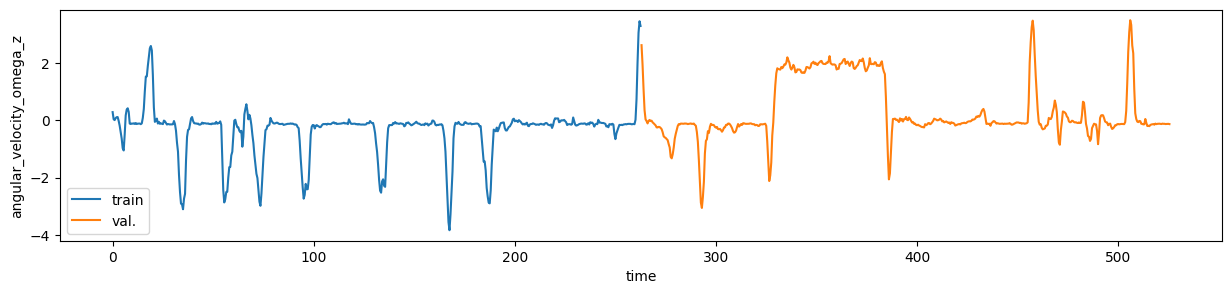

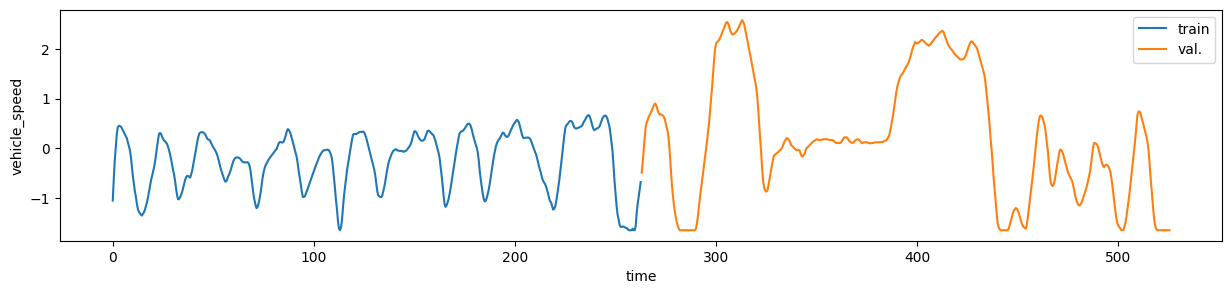

In [78]:
print('Inputs')
for i in range(U_train.shape[1]):
    plt.figure(figsize=(15,3))
    plt.plot(t_interp_train, U_train[:,i], label='train')
    plt.plot(t_interp_val, U_val[:,i], label='val.')
    plt.ylabel(input_signals[i])
    plt.xlabel('time')
    plt.legend()
plt.show()

print('Outputs')
for i in range(X.shape[1]):
    plt.figure(figsize=(15,3))
    plt.plot(t_interp_train, X_train[:,i], label='train')
    plt.plot(t_interp_val, X_val[:,i], label='val.')
    plt.ylabel(output_signals[i])
    plt.xlabel('time')
    plt.legend()

plt.show()

In [79]:
# Setup neural model structure
n_feat = 1024
ss_model = DeepNeuralStateSpaceModel(n_x=len(output_signals), n_u=len(input_signals), n_feat=n_feat).to(device)

In [80]:
# nn_solution = ForwardEulerSimulator(ss_model) #ForwardEulerSimulator(ss_model) #ExplicitRKSimulator(ss_model)
nn_solution = ExplicitRKSimulator(ss_model, ts=sampling_time_in_seconds, device=device) #ForwardEulerSimulator(ss_model) #ExplicitRKSimulator(ss_model)

In [81]:
# Set seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Overall parameters
num_iter = 250 # 4*500-100  # gradient-based optimization steps
seq_len = 128
batch_size = 64 # batch size q
lr = 1e-3  # learning rate
test_freq = 1  # print message every test_freq iterations
test_freq_val = 10 * test_freq # do validation every test_freq_val iterations
# add_noise = True

# Setup optimizer
params_net = list(nn_solution.ss_model.parameters())
optimizer = optim.Adam([
    {'params': params_net,    'lr': lr},
    # {'params': params_hidden, 'lr': 10*lr},
], lr=lr)

In [82]:
def lr_scheduler(step, lr0=1e-3, lr1=1e-5, T01=2000, T10=2000):
    T = T01 + T10
    
    s_mod = step % T
    
    if s_mod < T01:
        a = s_mod/T01
        lr = (1-a) * lr0 + a * lr1
    else:
        a = (s_mod-T01) / T10
        lr = (1-a) * lr1 + a * lr0
    return lr

def lr_scheduler_exp(step, lr0=1e-3, lr1=1e-5, T01=1000, T10=100, T2=10000, c=None):
# def lr_scheduler_exp(step, lr0=5e-3, lr1=1e-5, T01=220, T10=30, T2=2500, c=0.2):
    T = T01 + T10
    
    s_mod = step % T
    
    if s_mod < T01:
        a = s_mod/T01
        if c is not None:
            lr = lr0 * c**(step/T2) * (lr1/lr0)**(s_mod/T01)
        else:
            lr = lr0 * (lr1/lr0)**(s_mod/T01)
    else:
        a = (s_mod-T01) / T10
        if c is not None:
            lr = ((1-a) * lr1 + a * lr0) * c**(step/T2)
        else:
            lr = ((1-a) * lr1 + a * lr0)
    return lr

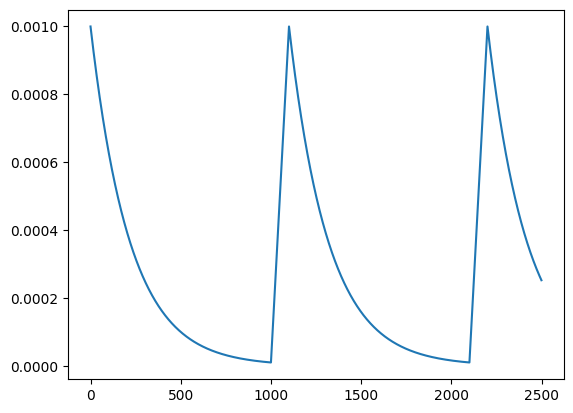

In [83]:
s = np.arange(2500)
plt.figure()
plt.plot(s, [lr_scheduler_exp(i) for i in s])
# plt.yscale('log')
plt.show()

In [84]:
# Batch extraction funtion
def get_batch(X, U, t, batch_size, seq_len):

    # Select batch indexes
    num_train_samples = X.shape[0]
    batch_start = np.random.choice(np.arange(num_train_samples - seq_len, dtype=np.int64), batch_size, replace=False) # batch start indices
    batch_idx = batch_start[:, np.newaxis] + np.arange(seq_len) # batch samples indices
    batch_idx = batch_idx.T  # transpose indexes to obtain batches with structure (m, q, n_x)

    # Extract batch data
    batch_t = torch.tensor(t[batch_idx].astype('float32'))
    batch_u = torch.tensor(U[batch_idx].astype('float32'))
    batch_x = torch.tensor(X[batch_idx].astype('float32'))

    return batch_t.to(device), batch_u.to(device), batch_x.to(device)


# Scale loss with respect to the initial one
with torch.no_grad():
    _, batch_u, batch_x = get_batch(X_train, U_train, t_interp_train, batch_size, seq_len)
    batch_x_sim = nn_solution(batch_x[0], batch_u)
    traced_nn_solution = torch.jit.trace(nn_solution, (batch_x[0], batch_u))
    err_init = batch_x_sim - batch_x
    scale_error = torch.sqrt(torch.mean(err_init**2, dim=(0, 1)))

LOSS = []
VAL_LOSS = []
start_time = time.time()

# Training loop

scripted_nn_solution = torch.jit.script(nn_solution)
for itr in range(0, num_iter):

    optimizer.zero_grad()
    # FIXME
    # optimizer.param_groups[0]['lr'] = lr_scheduler_exp(itr)

    # Simulate
    _, batch_u, batch_x = get_batch(X_train, U_train, t_interp_train, batch_size, seq_len)
    #batch_x_sim = traced_nn_solution(batch_x0_hidden, batch_u) # 52 seconds RK | 13 FE
    #batch_x_sim = nn_solution(batch_x0_hidden, batch_u) # 70 seconds RK | 13 FE
    # batch_x_sim = scripted_nn_solution(batch_x0_hidden, batch_u) # 71 seconds RK | 13 FE
    batch_x_sim = scripted_nn_solution(batch_x[0], batch_u) # 71 seconds RK | 13 FE

    # Compute fit loss
    err_fit = batch_x_sim - batch_x
    err_fit_scaled = err_fit/scale_error
    loss = torch.mean(err_fit_scaled**2)

    # Optimize
    loss.backward()
    optimizer.step()

    # Validation Performance
    if itr % test_freq_val == 0:
        do_val = True
        _, batch_u_val, batch_x_val = get_batch(X_val, U_val, t_interp_val, 1, U_val.shape[0]-1)
        with torch.no_grad():
            batch_x_sim_val = scripted_nn_solution(batch_x_val[0], batch_u_val) # 71 seconds RK | 13 FE
            loss_val = torch.mean(((batch_x_sim_val - batch_x_val) / scale_error)**2)
            VAL_LOSS.append(loss_val.item())
    
    # Statistics
    LOSS.append(loss.item())
    if itr % test_freq == 0:
        with torch.no_grad():
            if do_val:
                print(f'\rIter {itr} | Loss {loss:.4f}  Val Loss {loss_val} ', end='\n')
                do_val = False
            else:
                print(f'\rIter {itr} | Loss {loss:.4f}  ', end='')

train_time = time.time() - start_time
print(f"\nTrain time: {train_time:.2f}") 

Iter 0 | Loss 1.0309  Val Loss 2.7248995304107666 
Iter 10 | Loss 0.7999  Val Loss 2.812394857406616 
Iter 20 | Loss 0.4685  Val Loss 1.760936975479126 
Iter 30 | Loss 0.4071  Val Loss 1.2981458902359009 
Iter 40 | Loss 0.3515  Val Loss 1.22347092628479 
Iter 50 | Loss 0.3107  Val Loss 1.2149280309677124 
Iter 60 | Loss 0.2955  Val Loss 1.1134110689163208 
Iter 70 | Loss 0.2816  Val Loss 1.068874716758728 
Iter 80 | Loss 0.2665  Val Loss 1.0147042274475098 
Iter 90 | Loss 0.2802  Val Loss 1.042693018913269 
Iter 100 | Loss 0.2830  Val Loss 0.9396790862083435 
Iter 110 | Loss 0.2615  Val Loss 0.916109561920166 
Iter 120 | Loss 0.2592  Val Loss 0.889916718006134 
Iter 130 | Loss 0.2561  Val Loss 0.8598349094390869 
Iter 140 | Loss 0.2600  Val Loss 0.8474526405334473 
Iter 150 | Loss 0.2508  Val Loss 0.8533186316490173 
Iter 160 | Loss 0.2509  Val Loss 0.8362675905227661 
Iter 170 | Loss 0.2512  Val Loss 0.8407337069511414 
Iter 180 | Loss 0.2470  Val Loss 0.8423922061920166 
Iter 190 | L

In [85]:
# Save model
if not os.path.exists("models"):
    os.makedirs("models")

model_filename = f"model_SS_{seq_len}step_nonoise.pkl"
hidden_filename = f"hidden_SS_{seq_len}step_nonoise.pkl"

torch.save(nn_solution.ss_model.state_dict(), os.path.join("models", model_filename))
# torch.save(x_hidden_fit, os.path.join("models", hidden_filename))

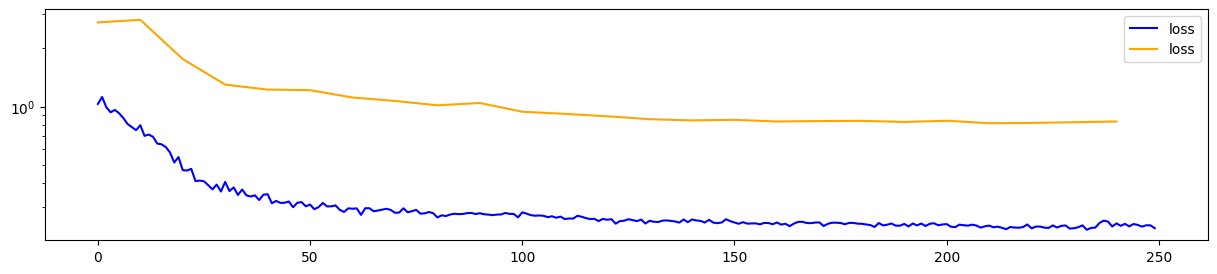

In [86]:
plt.figure(figsize=(15,3))
plt.plot(LOSS, label='loss', color='blue')
# plt.yscale('log')
# plt.figure(figsize=(15,3))
# plt.plot(VAL_LOSS, label='loss', color='orange')
plt.plot(np.arange(0, num_iter, test_freq_val/test_freq), VAL_LOSS, label='loss', color='orange')
plt.yscale('log')

# plt.plot(LOSS_CONSISTENCY, label='consistency loss')
# plt.plot(LOSS_FIT, label='fit loss')
plt.legend()
plt.show()

In [87]:
print(f'min(LOSS): {np.min(LOSS)}')
print(f'min(VAL_LOSS): {np.min(VAL_LOSS)}')
print(f'argmin(LOSS): {np.argmin(LOSS)}')
print(f'argmin(VAL_LOSS): {np.argmin(VAL_LOSS) * test_freq_val}')

min(LOSS): 0.22999218106269836
min(VAL_LOSS): 0.8195871710777283
argmin(LOSS): 233
argmin(VAL_LOSS): 210


In [88]:
def predict(x, u):
    x0 = x[0].astype('float32')
    x0_torch = torch.from_numpy(x0).to(device)
    u_torch = torch.tensor(u.astype('float32')).to(device)

    with torch.no_grad():
        x_sim_torch = nn_solution(x0_torch[None, :], u_torch[:, None, :])
        x_sim = x_sim_torch.squeeze(1).cpu().numpy()

    return x_sim

In [89]:
X_train_sim = predict(X_train, U_train)
X_val_sim = predict(X_val, U_val)

NameError: name 'save_plots_dir' is not defined

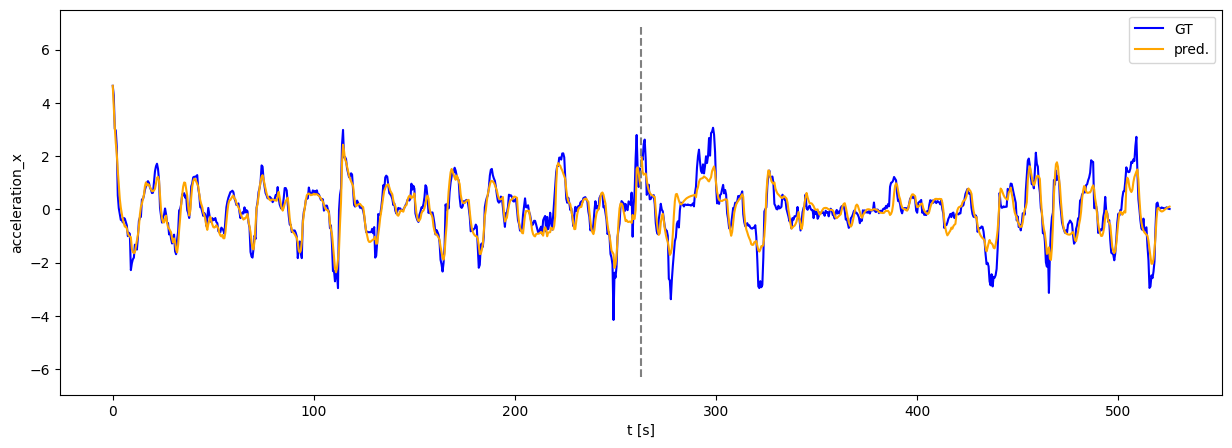

In [90]:
T = None

for i in range(X.shape[1]):
    plt.figure(figsize=(15,5))
    plt.plot(t_interp_train, X_train[:, i], label='GT', color='blue')
    plt.plot(t_interp_train, X_train_sim[:, i], label='pred.', color='orange')
    plt.plot([t_interp_train[-1]]*2, [np.min(X_train), np.max(X_train)], color='gray', linestyle='--')
    plt.plot(t_interp_val[:T], X_val[:T,i], color='blue')
    plt.plot(t_interp_val[:T], X_val_sim[:T,i], color='orange')
    plt.xlabel('t [s]')
    plt.ylabel(f'{output_signals[i]}')
    plt.legend()
    if not os.path.exists(save_plots_dir):
        os.makedirs(save_plots_dir)
    filename = os.path.join(save_plots_dir, f'train_test_curves_{output_signals[i]}_training{p_train}_sampling{sampling_time_in_seconds}_seqlen{seq_len}_nfeat{n_feat}_{variant_str}.png')
    plt.savefig(filename, bbox_inches='tight')
    plt.show()